# 1. Dependencies

In [86]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# 2. Data Preprocessing and Pipeline 

In [81]:
# reading  and analyzing the data files
train_df = pd.read_excel("../data/Train_dataset.xlsx", sheet_name="Train_dataset")
test_df = pd.read_excel("../data/Test_dataset.xlsx", sheet_name="Test_dataset")

## 2.1 Cleaning the data (Removing the redundant/irrelevant features)

In [79]:
## People_Id, Name does not determine(or might be but its rarest) Infect_prod, 
## Designation and Gender are same 

In [82]:
train_df = train_df.drop(columns=['Name', 'Designation', 'people_ID'], axis=1);
test_df = test_df.drop(columns=['Name', 'Designation'], axis=1)

In [87]:
train_df.head(5)

,Region,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,...,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,Bhubaneshwar,Female,YES,1.0,Farmer,Public,2,0,Hypertension,68,...,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010
1,Bhubaneshwar,Female,YES,2.0,Farmer,Walk,2,0,Diabetes,64,...,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880
2,Bhubaneshwar,Female,NO,1.0,Cleaner,Public,2,0,None,19,...,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000
3,Bhubaneshwar,Female,YES,1.0,Driver,Car,2,0,Coronary Heart Disease,33,...,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225
4,Bhubaneshwar,Female,NO,2.0,Manufacturing,Car,2,0,Diabetes,23,...,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800


In [88]:
from quilt.data.ResidentMario import missingno_data

In [89]:
collisions = missingno_data.nyc_collision_factors()

In [90]:
type(collisions)

pandas.core.frame.DataFrame

##### It appears like there is plethora of NaN values lets deat with e'm

## 2.1 EDA (Data Visualization)

### 2.1.1 Missing data visualisation, White fields indicate NaNs

In [94]:
train_copy = train_df.replace("nan", np.nan)

In [101]:
test_copy = test_df.replace("nan", np.nan)

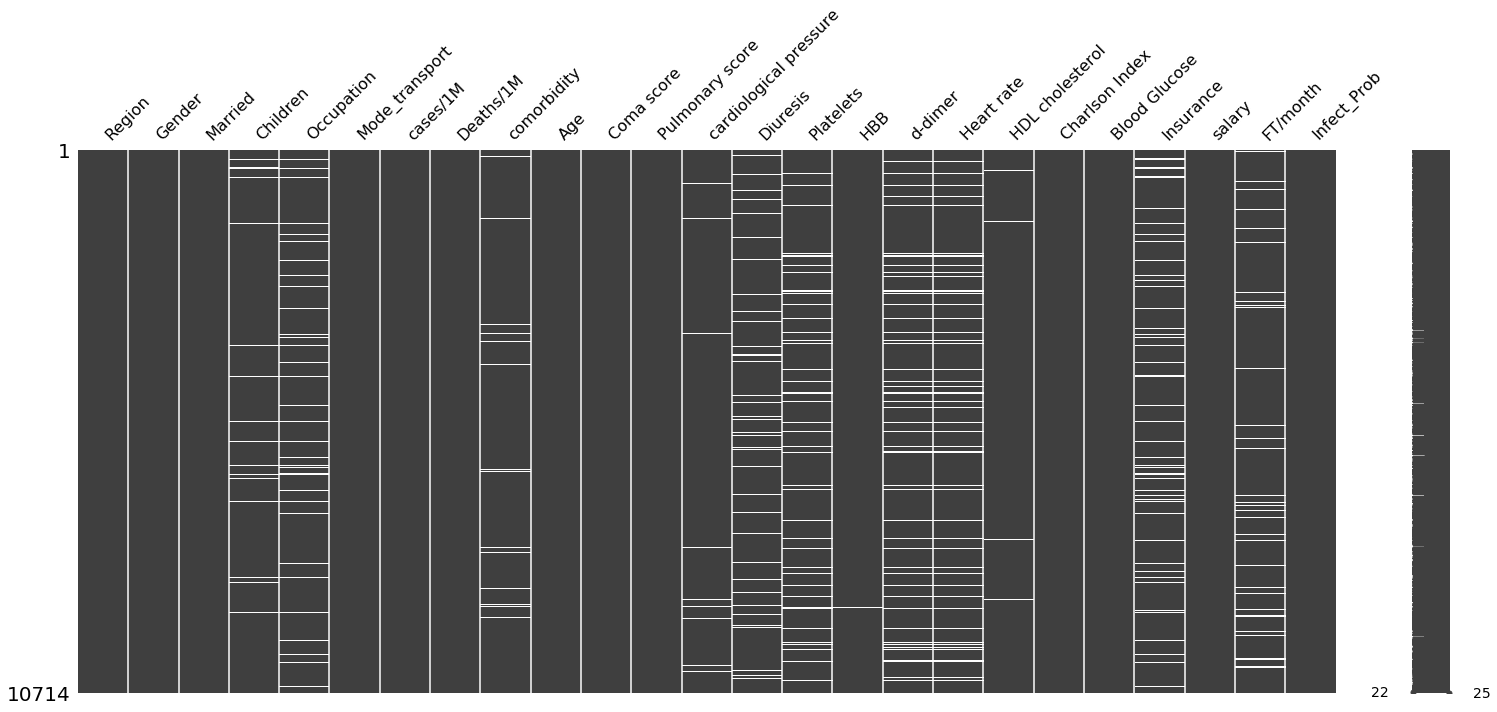

In [95]:
# missing values in training data
msno.matrix(train_copy);

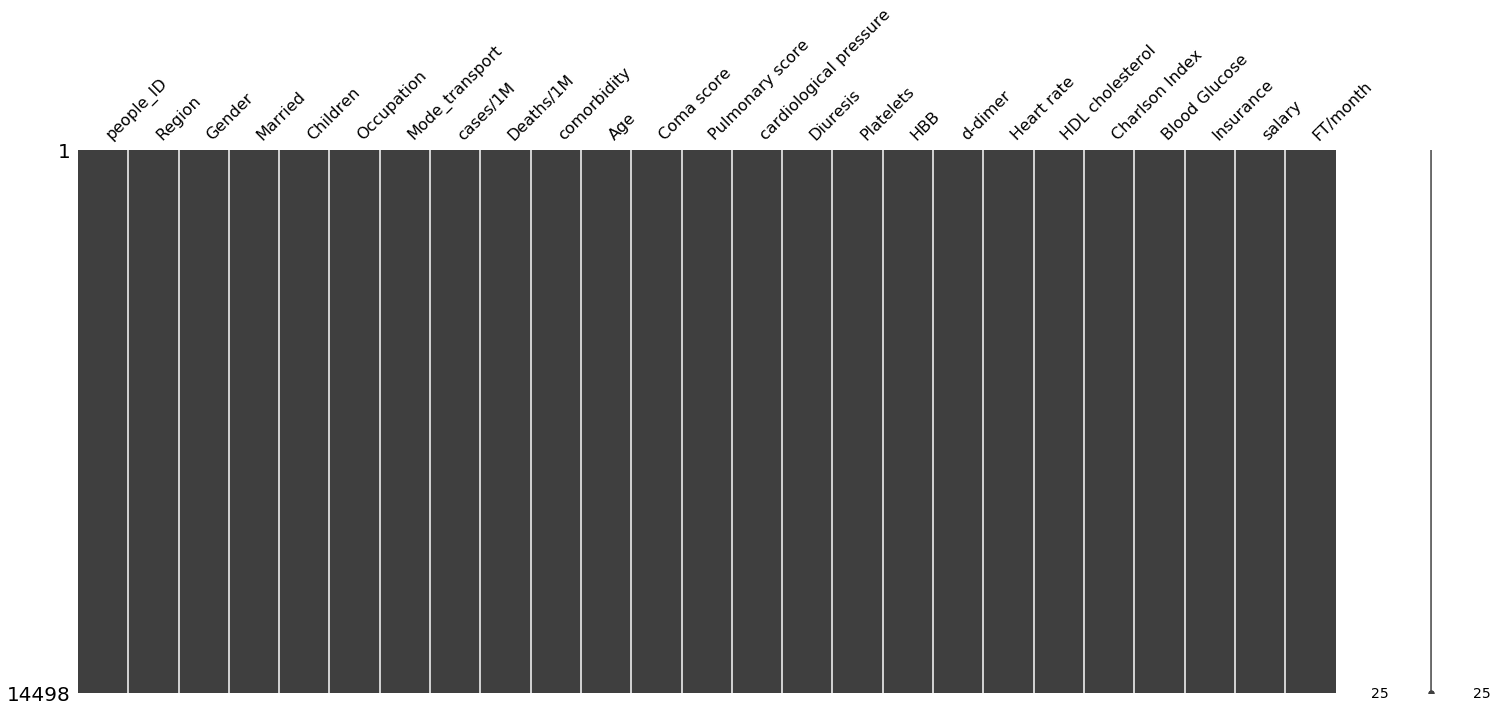

In [96]:
# missing values in test data (Its unlikely that there will be  any missing values in test data but lets c)
msno.matrix(test_df);

### 2.1.2 Correlation heatmap

In [98]:
# missingno heatmap measures nullity correlation, how the presence or absence or a variable
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 
# (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears 
# the other definitely also does).

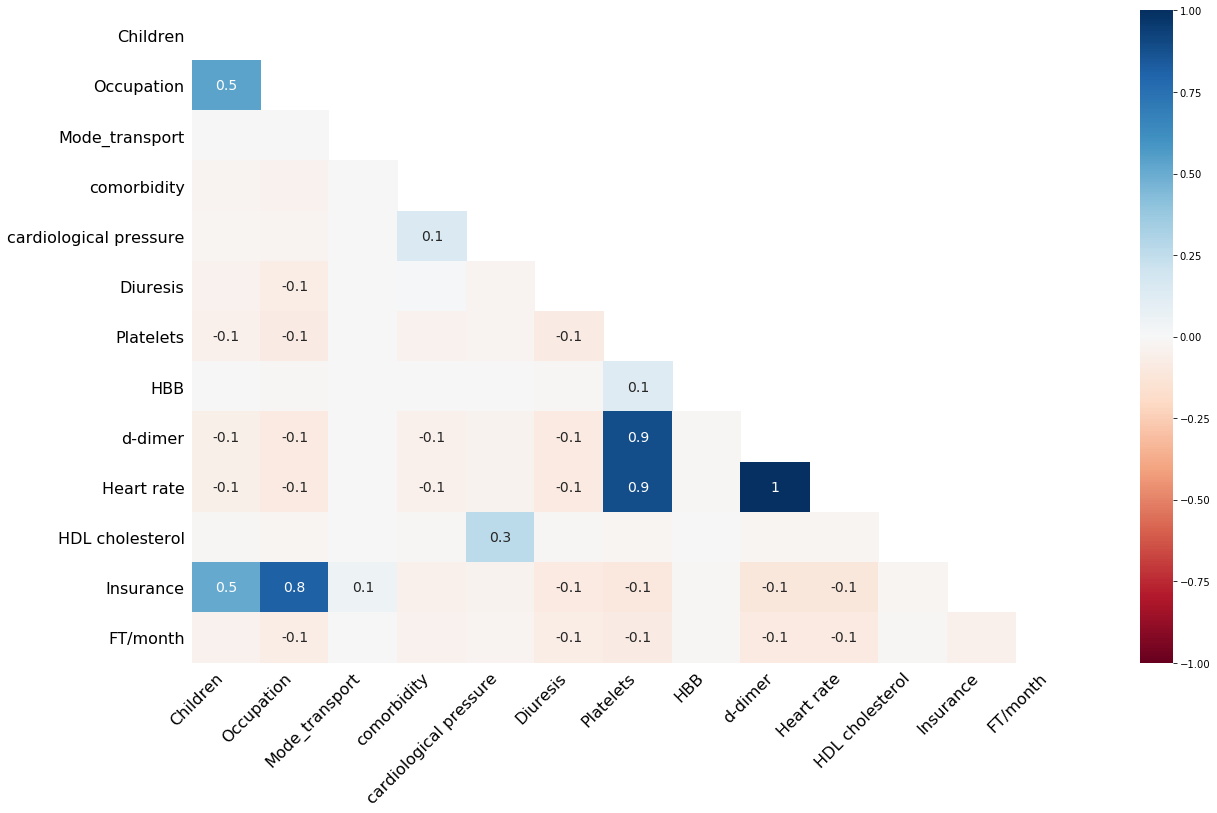

In [99]:
msno.heatmap(train_copy);

### 2.1.3 Dendrogram

In [ ]:
### The dendrogram allows us to more fully correlate variable completion, 
### revealing trends deeper than the pairwise ones visible in the correlation heatmap:

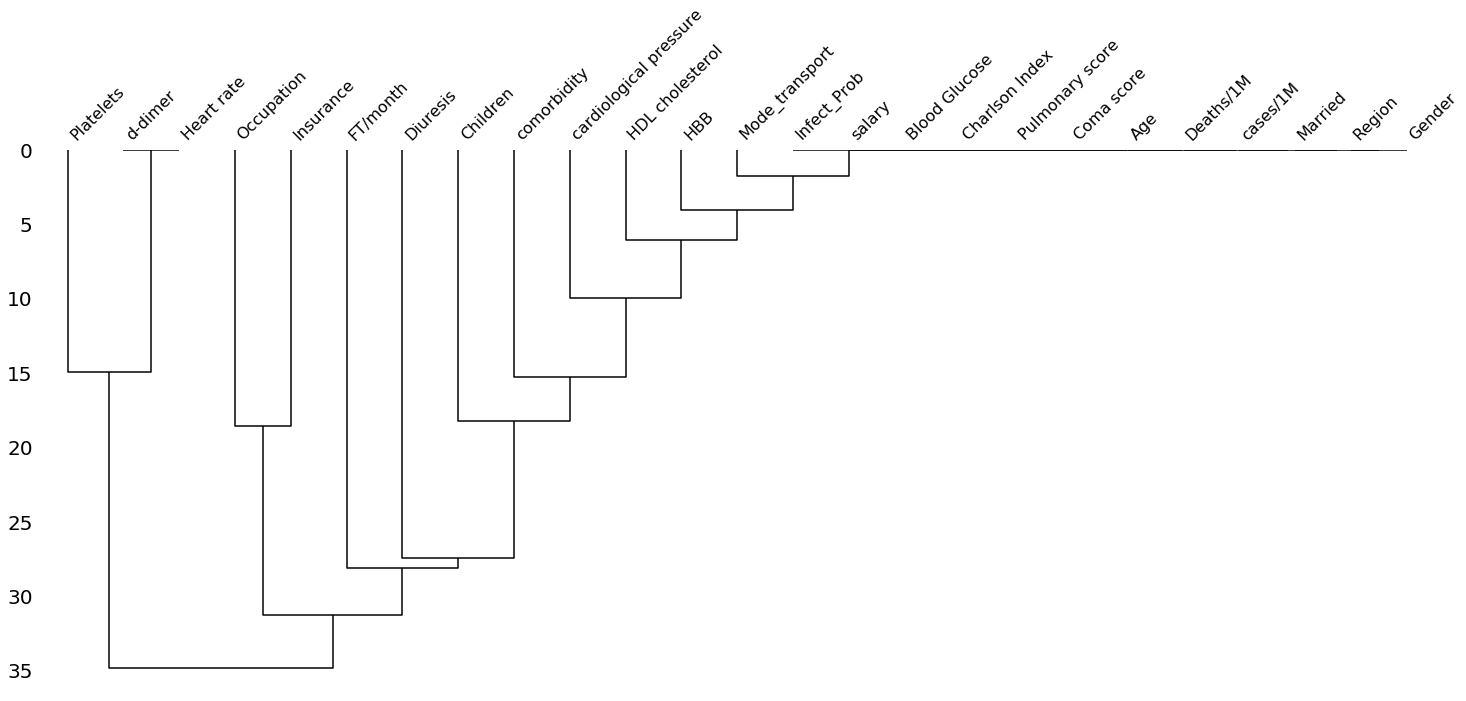

In [105]:
msno.dendrogram(train_copy);

## 2.2 Handling the Missing values
- We going to deal with the numerical missing data and categorical missing data differently

In [107]:
# how many missing values each col has
for col in train_df.columns:
    print(train_df[col].isnull().values.sum())

0
0
0
311
747
3
0
0
226
0
0
0
97
716
924
16
1114
1114
35
0
0
1090
0
723
0


In [50]:
num_train = train_df.select_dtypes(include='number');
cat_train = train_df.select_dtypes(exclude='number');

In [53]:
print(f'{train_df.shape[1] == num_train.shape[1] + cat_train.shape[1]}')

True


### 2.2.1 Numerical NaNs

In [106]:
from sklearn.impute import SimpleImputer

In [23]:
test_df.describe()

,people_ID,Children,cases/1M,Deaths/1M,Age,Coma score,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month
count,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,1.449800e+04,1.449800e+04,14498.000000
mean,14469.963167,0.978963,5.886743,1.342737,42.083667,8.985860,280.657608,86.886467,114.082977,274.667264,75.021727,52.417920,19.997448,4.995724,2.654849e+06,1.300021e+06,1.002966
std,6826.922260,0.811833,4.651725,0.953566,15.326426,3.754762,98.240677,42.194450,55.207974,43.706160,14.549680,10.341219,11.887840,1.416303,1.375384e+06,6.055975e+05,0.818952
min,3887.000000,0.000000,0.000000,0.000000,16.000000,3.000000,110.000000,15.000000,20.000000,200.000000,50.000000,35.000000,0.000000,3.000000,3.000000e+05,3.000000e+05,0.000000
25%,7747.250000,0.000000,3.000000,1.000000,29.000000,6.000000,195.000000,51.000000,66.000000,237.000000,63.000000,43.000000,10.000000,4.000000,1.500000e+06,8.000000e+05,0.000000
50%,16467.500000,1.000000,4.000000,1.000000,42.000000,9.000000,280.000000,87.000000,113.000000,274.000000,75.000000,52.000000,20.000000,5.000000,2.700000e+06,1.300000e+06,1.000000
75%,20315.750000,2.000000,11.000000,2.000000,55.000000,12.000000,366.000000,124.000000,162.000000,312.000000,88.000000,61.000000,30.000000,6.000000,3.800000e+06,1.800000e+06,2.000000
max,25212.000000,2.000000,13.000000,3.000000,68.000000,15.000000,450.000000,160.000000,210.000000,350.000000,100.000000,70.000000,40.000000,7.000000,5.000000e+06,2.300000e+06,2.000000


In [15]:
# coloums
cols = train_df.columns

In [18]:
print(cols)

Index(['people_ID', 'Region', 'Gender', 'Designation', 'Name', 'Married',
       'Children', 'Occupation', 'Mode_transport', 'cases/1M', 'Deaths/1M',
       'comorbidity', 'Age', 'Coma score', 'Pulmonary score',
       'cardiological pressure', 'Diuresis', 'Platelets', 'HBB', 'd-dimer',
       'Heart rate', 'HDL cholesterol', 'Charlson Index', 'Blood Glucose',
       'Insurance', 'salary', 'FT/month', 'Infect_Prob'],
      dtype='object')


In [ ]:
## The usual suspects for less important independent variables are
# people_ID, Gender(I doubt though), Designation and Name
# lets see the correlation with the target values

In [20]:
usual_suspects = ['people_ID', 'Gender', 'Name', 'Children', 'Designation', 'Occupation']

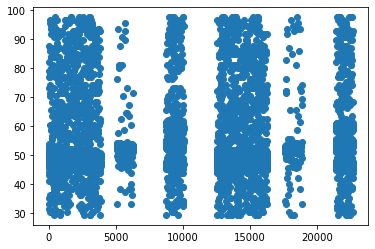

In [19]:
plt.scatter(train_df.people_ID.values, train_df.Infect_Prob.values)

In [39]:
# for each in usual_suspects:

#     figure = plt.figure
#     ax = plt.gca()
#     ax.scatter(train_df[each], train_df.Infect_Prob)
#     ax.set_xlabel(each)
#     ax.set_ylabel(train_df.Infect_Prob)
#     ax.set_title("{} vs {}".format(train_df.Infect_Prob, each))

#     plt.legend()
#     plt.show()

TypeError: nan is not a string

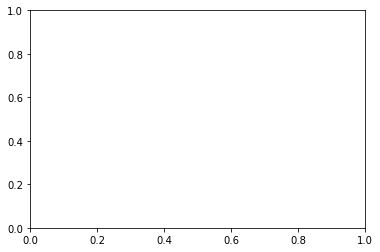

In [40]:
plt.scatter(train_df.Name, train_df.Infect_Prob)